In [2]:
import json
import os
import PIL.Image
import torch
import numpy as np
from sklearn.cluster import KMeans

use_gpu = torch.cuda.is_available()
device = torch.device('cuda') if use_gpu else torch.device('cpu')

In [3]:
# calculate stroke size ratio and store json record
stroke_direct = "resource/flower/single_strokes/"
allFileList = os.listdir(stroke_direct)
allFileList.sort()
loss_list = []
for file in allFileList:
    file_path = os.path.join(stroke_direct, file)
    gt = np.array(PIL.Image.open(file_path))
    if gt.shape[2] == 4:
        #print("Input image includes alpha channel, simply dropout alpha channel.")
        gt = gt[:, :, :3]

    gt = (gt/255).astype(np.float32)
    gt = torch.FloatTensor(gt).permute(2, 0, 1)[None].to(device)
    gt = gt.detach().cpu().numpy()

    h, w = gt.shape[2:]
    para_bg = torch.tensor([1., 1., 1.], requires_grad=False, device=device)
    pred = para_bg.view(1, -1, 1, 1).repeat(1, 1, h, w)
    pred = pred.detach().cpu().numpy()

    map = ((pred[0] - gt[0])**2).sum(0)
    pixel_num = w*h
    zero_count = len(map[map==0.0])
    ratio = zero_count / pixel_num
    loss_list.append("{:.4f}".format(ratio))

results = {
    'size': loss_list,
}

with open(f'./stroke_size.json', 'w') as writer:
    json.dump(results, writer, indent=4)

In [4]:
f = open('./stroke_size.json')
data = json.load(f)
loss = np.array(data['size'])
loss = (loss.reshape(-1, 1)).astype(np.float32)
print(loss.shape)

(495, 1)


In [5]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(loss)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

c:\Users\cg\anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cg\anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


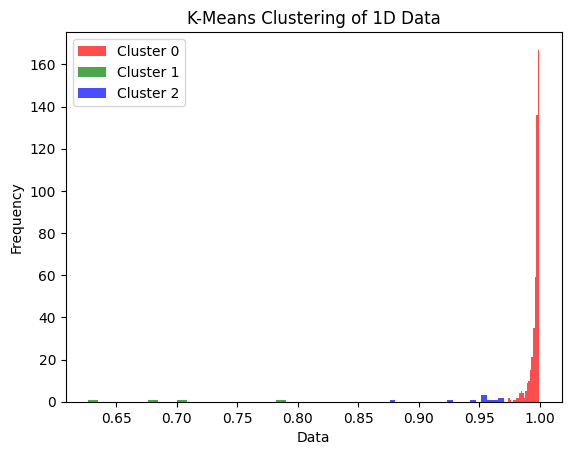

In [7]:
import matplotlib.pyplot as plt
plt.hist(loss[labels == 0], bins=20, color='red', alpha=0.7)  # 繪製屬於cluster 0的數據的直方圖
plt.hist(loss[labels == 1], bins=20, color='green', alpha=0.7)  # 繪製屬於cluster 1的數據的直方圖
plt.hist(loss[labels == 2], bins=20, color='blue', alpha=0.7)  # 繪製屬於cluster 2的數據的直方圖
# plt.hist(loss[labels == 3], bins=20, color='black', alpha=0.7)  # 繪製屬於cluster 1的數據的直方圖
# plt.hist(loss[labels == 4], bins=20, color='yellow', alpha=0.7)  # 繪製屬於cluster 2的數據的直方圖


plt.xlabel('Data')
plt.ylabel('Frequency')
plt.title('K-Means Clustering of 1D Data')
plt.legend([ 'Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.show()

In [8]:
cluster_ranges = []
num = []
for i in range(kmeans.n_clusters):
    cluster_data = loss[kmeans.labels_ == i]
    cluster_min = np.min(cluster_data)
    cluster_max = np.max(cluster_data)
    cluster_num = len(cluster_data)
    cluster_ranges.append((cluster_min, cluster_max,cluster_num))

# 輸出結果
for i, (min_val, max_val, num)  in enumerate(cluster_ranges):
    print("Cluster {}: Range = [{}, {}], numbers = {}".format(i, min_val, max_val, num))

print(centers)

Cluster 0: Range = [0.9739000201225281, 0.9997000098228455], numbers = 481
Cluster 1: Range = [0.6269999742507935, 0.7904000282287598], numbers = 4
Cluster 2: Range = [0.8761000037193298, 0.9707000255584717], numbers = 10
[[0.99649835]
 [0.699175  ]
 [0.94694   ]]


In [9]:
record = {}
record['label'] = labels.tolist()
results = record
with open(f'stroke_size_clustering_results.json', 'w') as writer:
    json.dump(results, writer, indent=4)